In [ ]:
!pip install scikit-maad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import librosa
import librosa.display
from librosa import feature
from maad import sound
from time import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
plt.rcParams["figure.figsize"] = (17, 5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%% Set variables
path_annotations = '/content/drive/MyDrive/DS4All_Cohort6_Team_172/Code/data/ANH_RAIN_DATASET/audio_labels.csv'  # manual annotations in csv table
path_audio = '/content/drive/MyDrive/DS4All_Cohort6_Team_172/Code/data/ANH_RAIN_DATASET/audio/'  # directory where the audio data is located
path_results = '/content/drive/MyDrive/DS4All_Cohort6_Team_172/Code/results/'
target_fs = 10000  # set target sampling rate for audio

In [ ]:
#%% Load annotations
df = pd.read_csv(path_annotations)  

In [ ]:
df.shape

(1104, 7)

In [ ]:
df.head()

,fname,label,max_f,max_t,min_f,min_t,sample_idx
0,G001_20211112_030000.WAV,SENSAT,47297.562,5.0,47297.562,0.0,0000.wav
1,G001_20211112_180000.WAV,MURCIE,44956.098,5.0,24819.512,0.0,0001.wav
2,G001_20211112_183000.WAV,INSECT,51980.490,5.0,3721.417,0.0,0002.wav
3,G001_20211112_203000.WAV,MURCIE,33482.926,5.0,16776.250,0.0,0003.wav
4,G001_20211112_220000.WAV,SENSAT,24585.365,5.0,24585.365,0.0,0004.wav


In [ ]:
df.to_excel(path_results+'gas.xlsx')

In [ ]:
#%% Compute features
df_features = pd.DataFrame()

# Calculate for each feature, time of extraction

for idx_row, row in tqdm(df.iterrows()):
    t0_features = time()
    full_path_audio = os.path.join(path_audio, row.sample_idx)
    s, fs = sound.load(full_path_audio)
    # resample    
    s_resamp = sound.resample(s, fs, target_fs, res_type='kaiser_fast')
    # transform
    # Mel-frequency cepstral coefficients (MFCCs)
    mfcc = feature.mfcc(y=s_resamp, sr=target_fs, n_mfcc=20, n_fft=1024, 
                        win_length=1024, hop_length=512, htk=True)
    mfcc = np.median(mfcc, axis=1)
    # format dataframe
    idx_names = ['mfcc_' + str(idx).zfill(2) for idx in range(1,mfcc.size+1)]
    row = row.append(pd.Series(mfcc, index=idx_names))
    row.name = idx_row
    df_features = df_features.append(row)
  

duration = round(time() - t0_features,2)
print('Feature:', 'Extraction Time:',duration)

1104it [02:15,  8.16it/s]

Feature: Extraction Time: 0.11


In [ ]:
full_path_audio

'/content/drive/MyDrive/DS4All_Cohort6_Team_172/Code/data/ANH_RAIN_DATASET/audio/1103.wav'

In [ ]:
s, fs = sound.load('/content/drive/MyDrive/DS4All_Cohort6_Team_172/Code/data/ANH_RAIN_DATASET/audio/0008.wav')
s_resamp = sound.resample(s, fs, target_fs, res_type='kaiser_fast')
S = feature.melspectrogram(y=s_resamp, sr=target_fs,n_mels=128,
                                    fmax=8000)

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

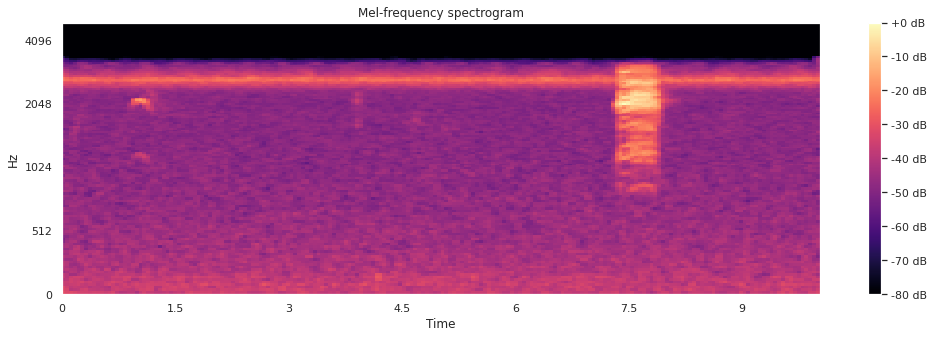

In [ ]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=target_fs,
                         ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
df_features['label_english'] = df_features['label'].replace({'SENSAT':'Saturated',
                                                    'MURCIE':'Bats',
                                                    'INSECT':'Insects',
                                                    'LLUVIA':'Rain',
                                                    'PULSOS':'Pulses', 
                                                    'HERPET':'Amphibian',
                                                    'ANTROP':'Anthrophony',
                                                    'AVEVOC':'Birds', 
                                                    'TRAMOT':'Motors',#'Transporte Motorizado', 
                                                    'INDETE':'Undetermined', 
                                                    'PASOS': 'Footsteps', #'Pasos', 
                                                    'FLUAGU':'Rainfall',
                                                    'ANIDOM': 'Domestic Animals' #'Animales Domésticos'
                                                     })

df_features['soundscape_label'] = df_features['label'].replace({
                                                        'SENSAT':'Other',
                                                        'MURCIE':'Biophony',
                                                        'INSECT':'Biophony',
                                                        'LLUVIA':'Geophony',
                                                        'PULSOS':'Other', 
                                                        'HERPET':'Biophony',
                                                        'ANTROP':'Anthrophony',
                                                        'AVEVOC':'Biophony', 
                                                        'TRAMOT':'Anthrophony', 
                                                        'INDETE':'Other', 
                                                        'PASOS': 'Anthrophony',
                                                        'FLUAGU':'Geophony',
                                                        'ANIDOM': 'Anthrophony'
                                                    })

In [ ]:
df_features_plot = df_features.drop(columns=['fname','max_f','max_t','min_f','min_t','sample_idx'])


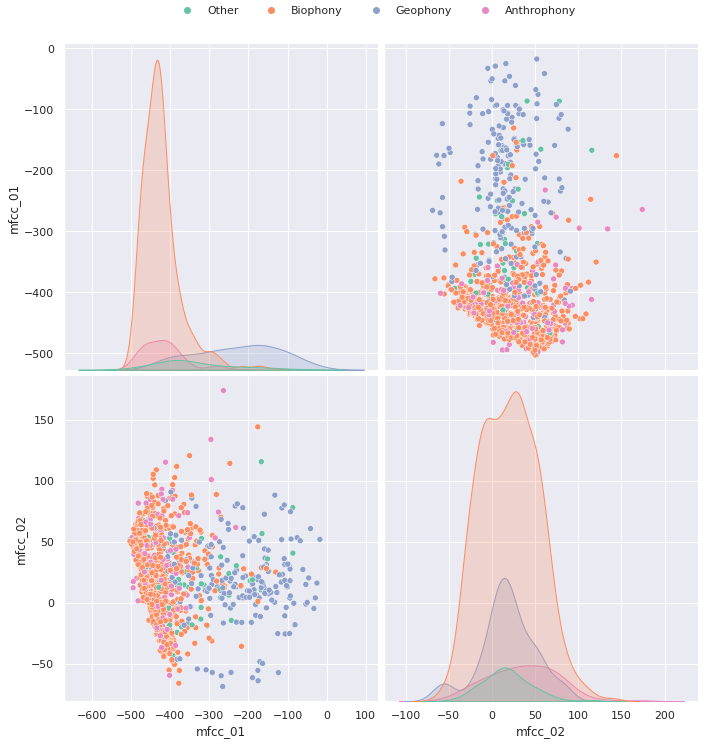

In [ ]:
ax = sns.pairplot(df_features_plot[['mfcc_01','mfcc_02','soundscape_label']], hue="soundscape_label", palette="Set2", diag_kind="kde", height=5)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.45, 1), ncol=4, title=None, frameon=False,
)

mfcc_01                                                  \
                   count        mean         std         min         25%   
soundscape_label                                                           
Anthrophony        102.0 -418.326828   53.560860 -497.739335 -459.128162   
Biophony           746.0 -423.395192   51.218865 -502.942242 -457.476279   
Geophony           200.0 -230.136330  108.351862 -448.697656 -306.092316   
Other               56.0 -337.733234   98.695592 -502.822111 -397.748532   

                                                     mfcc_02             \
                         50%         75%         max   count       mean   
soundscape_label                                                          
Anthrophony      -421.615485 -394.469220 -232.260782   102.0  35.899447   
Biophony         -432.948950 -408.904012 -130.456872   746.0  20.129327   
Geophony         -218.333826 -149.475144  -17.300672   200.0  18.228165   
Other            -367.635269 -274.798343  -86.269533    56.0  17.899764   

                                                                        \
                        std        min       25%        50%        75%   
soundscape_label                                                         
Anthrophony       40.867002 -59.556255  6.439686  35.932158  65.840218   
Biophony          33.964432 -66.031239 -6.966148  19.648816  46.030723   
Geophony          31.935062 -68.720571  3.794928  17.125596  36.942784   
Other             28.342134 -43.207346 -2.877879  14.946213  31.405746   

                              
                         max  
soundscape_label              
Anthrophony       174.063826  
Biophony          144.254055  
Geophony           90.825282  
Other             115.707200

In [ ]:
g = sns.pairplot(df_features_plot, hue="label", palette="Set2", diag_kind="kde", height=2.5)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ax = sns.barplot(data=df_scores,x='Method',y='Performance',hue='Metric Score',ci="sd")
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
ax.set_title('Performance of differents rain classifiers using MFCC', fontdict = {'fontsize' : 20}, pad=35)
plt.xticks(rotation=45)
plt.show()

NameError: ignored

In [ ]:
sns.barplot(data=df_scores,x='Method',y='Classifier Time')
plt.xticks(rotation=45)
plt.title('Time Performance of differents rain classifiers using MFCC')

In [ ]:
df_scores.groupby(['Method','Metric Score'])['Performance'].agg(['mean', 'std'])

In [ ]:
df_features.head()

In [ ]:
df_features['lluvia'] = df_features['label'].apply(lambda x: 'Rain' if x=='LLUVIA' else 'No Rain')

In [ ]:
df_features['label'].unique()

In [ ]:
# plot inside big category
plt.figure(figsize=(27, 10))
ax = df_features['label'].value_counts().plot.pie(autopct='%1.1f%%',pctdistance=1.15, labeldistance=1.25,)
ax.set_title("Percentage of labels in Sample Dataset", fontdict = {'fontsize' : 20}, pad=35)
plt.axis('off')
plt.show()